In [35]:
import numpy as np
import matplotlib.pyplot as plt
import xtrack as xt
import xpart as xp
import xobjects as xo
import xcoll as xc
from pathlib import Path
import json

import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [19]:
dir = Path('/Users/lisepauwels/sps_simulations/Prototyping/20251009/results/')
subdirs = [p for p in dir.iterdir() if p.is_dir()]
cases = [p.stem for p in subdirs]

cases, subdirs = zip(*sorted(zip(cases, subdirs)))
cases = list(cases)
subdirs = list(subdirs)

In [23]:
with open(subdirs[0]/f'IntensityLoss_{cases[0]}.json', 'r') as fid:
    input_data = json.load(fid)

In [26]:
def df_to_delta(df):
    sps_gtr = 17.95
    sps_g0 = 27.643
    f0 = 200e6
    eta = 1/sps_gtr**2 - 1/sps_g0**2
    return -df/(f0*eta)

In [39]:
def interpolate_50_val(xvals, yvals):
    if np.any(yvals <= 0.5):  # ensure the curve actually crosses 0.5
        idx_above = np.where(yvals > 0.5)[0][-1]   # last index above 0.5
        idx_below = idx_above + 1                  # first index below 0.5

        # Linear interpolation for more accuracy
        x50 = np.interp(0.5, [yvals[idx_above], yvals[idx_below]],
                            [xvals[idx_above], xvals[idx_below]])
        return x50
    else:
        print("Warning: The curve does not cross 0.5")
        return None

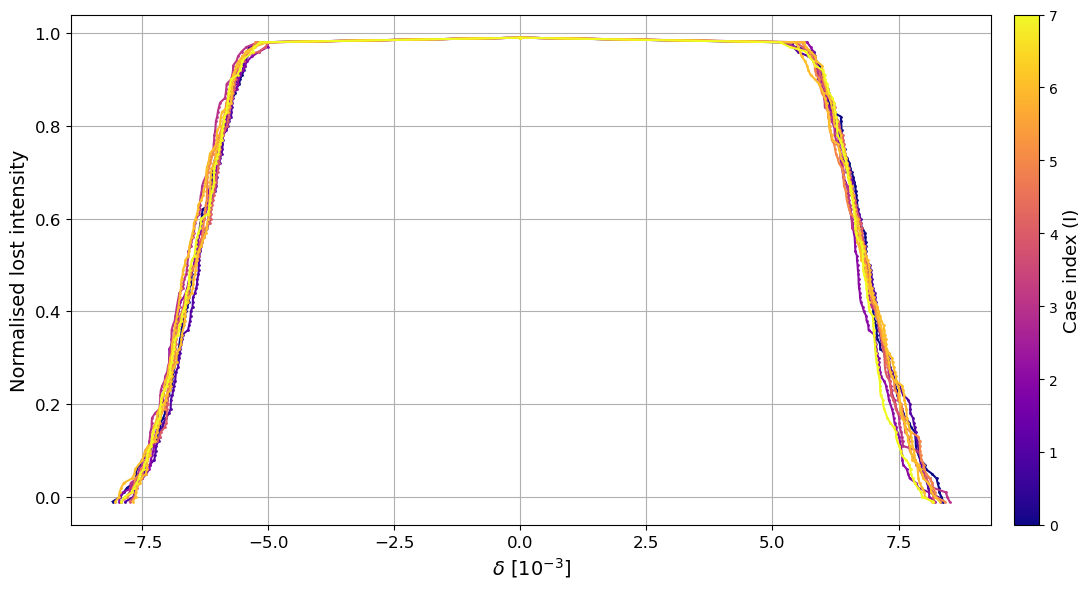

In [42]:
fig, ax = plt.subplots(figsize=(12,6))

case_indices = sorted({
    int(c.split('_')[0].replace('case', ''))
    for c in cases
    if c not in ['case7_1000part_DPneg', 'case7_1000part_DPpos', 'case6_bis_DPneg', 'case6_bis_DPpos']
})

cmap = cm.plasma
norm = mcolors.Normalize(vmin=min(case_indices), vmax=max(case_indices))
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])


for case, subdir in zip(cases, subdirs):
    if case not in ['case7_1000part_DPneg', 'case7_1000part_DPpos']:#, 'case6_bis_DPneg', 'case6_bis_DPpos']:
        with open(subdir/f'IntensityLoss_{case}.json', 'r') as fid:
            input_data = json.load(fid)
        turns = list(input_data.keys())
        num_particles = input_data['num_particles']
        sweep_per_turn = input_data['sweep_per_turn']
        turns.remove('num_particles')
        turns.remove('sweep_per_turn')

        turns = np.array(turns, dtype=int)
        deltas = df_to_delta(sweep_per_turn*turns)
        deltas = np.concatenate((np.array([0]), deltas))
        counts = np.array([input_data[str(turn)] for turn in turns], dtype=int)
        counts = np.concatenate((np.array([1]), counts))

        I = int(case.split('_')[0].replace('case', ''))
        color = cmap(norm(I))


        ax.plot(deltas*1e3, 1-np.cumsum(counts)/num_particles, marker='o', markersize=1, color=color, label=case)
        # ax.vlines()
ax.grid()
ax.set_xlabel(r'$\delta$ $[10^{-3}]$', fontsize=14)
ax.set_ylabel('Normalised lost intensity', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label('Case index (I)', fontsize=13)

fig.tight_layout()